In [ ]:
from ml_t6.preprocessing_seniority import Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import shap
import numpy as np
import pandas as pd

In [3]:
data = Preprocessing(
    X_link="/Users/jonas/Documents/Master_Vorlesungen/Semester_02/Practical Data Science/Final/PDS_Final/data/linkedin-cvs-annotated.json",
    seniority_link  = "/Users/jonas/Documents/Master_Vorlesungen/Semester_02/Practical Data Science/Final/PDS_Final/data/seniority-v2.csv",
    department_link = "/Users/jonas/Documents/Master_Vorlesungen/Semester_02/Practical Data Science/Final/PDS_Final/data/department-v2.csv"
)

data.data_pipeline()


X_train, X_test, y_train, y_test = train_test_split(
    data.X, data.Y,
    test_size=0.2,
    random_state=42,
    stratify=data.Y
)

8 duplicates have been removed
6 seniorities found:
['junior', 'professional', 'senior', 'lead', 'management', 'director']
Dropped (no ACTIVE job or missing startDate): 152
Dropped (ACTIVE job missing seniority label): 0


In [4]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestClassifier(random_state=42, n_jobs=-1, class_weight="balanced"))
])

param_dist = {
    "rf__n_estimators": [200, 300, 400, 500],
    "rf__max_depth": [None, 5, 10, 20, 40],
    "rf__min_samples_split": [2, 5, 10, 20],
    "rf__min_samples_leaf": [1, 2, 4, 8],
    "rf__max_features": ["sqrt", "log2", None, 0.3, 0.5, 0.8],
    "rf__bootstrap": [True, False],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=40,
    scoring="neg_mean_absolute_error",
    cv=cv,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train, y_train)

print("Best CV score:", search.best_score_)
print("Best params:\n", search.best_params_)

best_model = search.best_estimator_

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] END rf__bootstrap=False, rf__max_depth=40, rf__max_features=0.8, rf__min_samples_leaf=8, rf__min_samples_split=20, rf__n_estimators=300; total time=   0.5s
[CV] END rf__bootstrap=False, rf__max_depth=40, rf__max_features=0.8, rf__min_samples_leaf=8, rf__min_samples_split=20, rf__n_estimators=300; total time=   0.5s
[CV] END rf__bootstrap=False, rf__max_depth=40, rf__max_features=0.8, rf__min_samples_leaf=8, rf__min_samples_split=20, rf__n_estimators=300; total time=   0.5s
[CV] END rf__bootstrap=True, rf__max_depth=5, rf__max_features=0.8, rf__min_samples_leaf=4, rf__min_samples_split=10, rf__n_estimators=400; total time=   0.6s
[CV] END rf__bootstrap=True, rf__max_depth=5, rf__max_features=0.8, rf__min_samples_leaf=4, rf__min_samples_split=10, rf__n_estimators=400; total time=   0.6s
[CV] END rf__bootstrap=True, rf__max_depth=5, rf__max_features=0.8, rf__min_samples_leaf=4, rf__min_samples_split=10, rf__n_estimators=40

In [5]:
y_pred = best_model.predict(X_test)
print("\nTest accuracy:", accuracy_score(y_test, y_pred))
print("\nTest report:\n", classification_report(y_test, y_pred))
print("Ordinal MAE:", mean_absolute_error(y_test, y_pred))


Test accuracy: 0.31521739130434784

Test report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.37      0.48      0.42        31
           2       0.08      0.12      0.10         8
           3       0.23      0.26      0.24        19
           4       0.67      0.30      0.41        27
           5       0.00      0.00      0.00         5

    accuracy                           0.32        92
   macro avg       0.22      0.19      0.20        92
weighted avg       0.37      0.32      0.32        92

Ordinal MAE: 1.3369565217391304


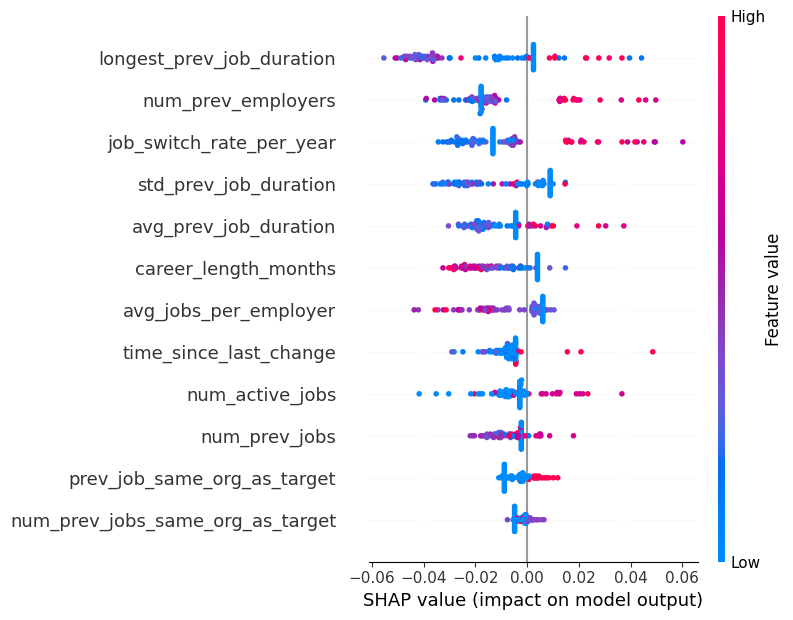

In [ ]:
scaler = best_model.named_steps["scaler"]
rf = best_model.named_steps["rf"]

X_explain = X_test.iloc[:200].copy()
X_explain_scaled = pd.DataFrame(scaler.transform(X_explain), columns=X_explain.columns)

explainer = shap.TreeExplainer(rf)
sv = explainer.shap_values(X_explain_scaled, check_additivity=False)

if isinstance(sv, list):
    class_id = 0
    shap.summary_plot(sv[class_id], X_explain_scaled, feature_names=X_explain_scaled.columns)
else:
    class_id = 0
    shap.summary_plot(sv[:, :, class_id], X_explain_scaled, feature_names=X_explain_scaled.columns)

In [ ]:
explainer = shap.TreeExplainer(rf)
sv = explainer.shap_values(X_explain_scaled, check_additivity=False)

print(type(sv))
if isinstance(sv, list):
    print("List length (n_classes):", len(sv))
    print("sv[0].shape:", sv[0].shape)
else:
    print("sv.shape:", sv.shape)

<class 'numpy.ndarray'>
sv.shape: (92, 12, 6)


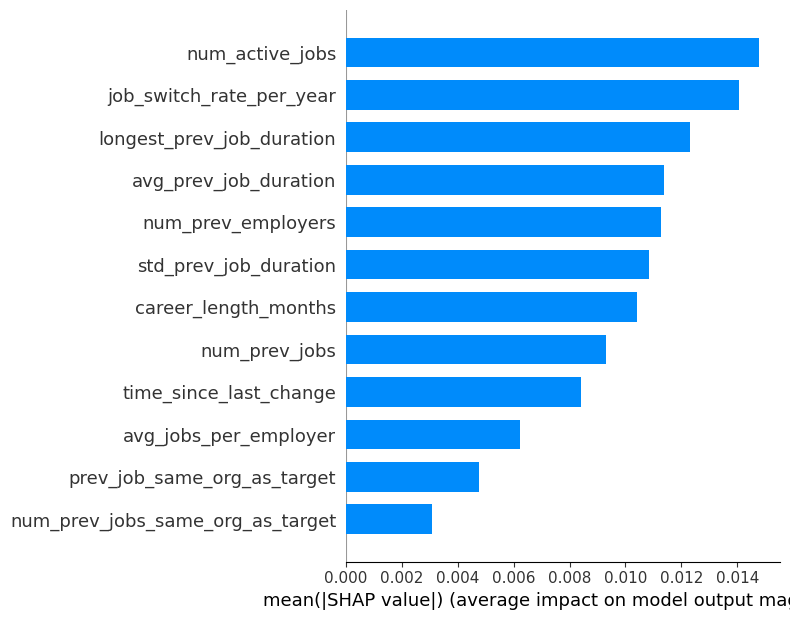

In [ ]:
if isinstance(sv, list):
    sv_abs = np.mean([np.abs(s) for s in sv], axis=0)
else:
    sv_abs = np.mean(np.abs(sv), axis=2)

shap.summary_plot(sv_abs, X_explain_scaled, feature_names=X_explain_scaled.columns, plot_type="bar")
